In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### First exploration of machine learning, adding one hot encoding for categorical features

In [2]:
df= pd.read_csv('Data/income_data_2017_clean_zeros.csv.bz2', compression='bz2', index_col='peridnum')

In [3]:
categorical_features = ['PEIOOCC', 'A_HGA', 'PRDTRACE', 'FKIND', 'A_CLSWKR', 'A_WKSTAT',
                       'A_MJIND', 'MJOCC', 'PTYN', 'LJCW', 'A_SEX', 'WEMOCG', 'MIG_CBST',
                       'MIGSAME', 'H_TYPE', 'H_LIVQRT', 'GTCBSA', 'GESTFIPS']
numerical_features = ['H_NUMPER', 'FPERSONS', 'FOWNU6', 'FOWNU18', 'A_AGE', 'A_HRS1',
                     'A_USLHRS', 'PHMEMPRS', 'HRSWK', 'HNUMFAM']
labels = ['ERN_VAL']
features = categorical_features + numerical_features

The column names in the the documentation are uppercase and in the csv file lowercase. Until I decide on a uniform format I just convert the csv to uppercase after loading.

In [4]:
# converting colum names to uppercase
df.columns = df.columns.str.upper()

In [5]:
df_filt = df[features + labels]
df_filt = df_filt[(df_filt['ERN_VAL'] > 3000) & (df['ERN_VAL'] < 250000)]

In [6]:
# Getting the index of categorical variables for the OneHot encoder.
categorical_index = [i for i,x in enumerate(df_filt.columns.values) if x in categorical_features]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [8]:
X = df_filt[features].values
# Setting a binary tager from the ern_val column
y = (df_filt.ERN_VAL > 40000).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In the preliminary tests Gradient Boosting classifier was the most promising, so I'm using it. I'm still not adjusting parameters, so there is no need for cross validation. Later I will do a grid search with cross validation for this and some other promising classifiers. 

In [9]:
steps = [('onehot', OneHotEncoder(categorical_features=categorical_index)),
        ('gradientboost', GradientBoostingClassifier(n_estimators=320,subsample=0.3
                                                     , learning_rate=0.2, max_depth=3))]
pipeline = Pipeline(steps)

In [10]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=True)), ('gradientboost', GradientBoostingClassifier(criterion='friedman_mse', init=None,
...      presort='auto', random_state=None, subsample=0.3, verbose=0,
              warm_start=False))])

In [11]:
print(pipeline.score(X_test, y_test))

0.803674626540181


### Evaluating the classifier 

As an initial evaluation I'll get the f-1 score and the AUC for the model. This will be used as a baseline for comparison for later optimizations.

In [12]:
import sklearn.metrics as met
y_pred = pipeline.predict(X_test)
print(met.confusion_matrix(y_test,y_pred, labels=[0,1]))
print(f'{f-1 Score: {met.f1_score(y_test,y_pred)}')

[[10372  1494]
 [ 2107  4369]]
0.7081611151633034


In [13]:
y_score = pipeline.decision_function(X_test)
fpr, tpr, threshold = met.roc_curve(y_test, y_score)

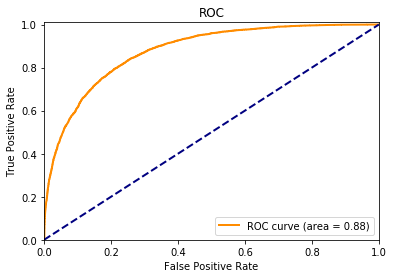

array([ 1.33674330e+32,  1.33674330e+32,  5.97969491e+00, ...,
       -5.52434370e+00, -5.53795819e+00, -7.43419243e+00])

In [14]:
plt.figure()
lw = 2
auc = met.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = {:0.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
threshold

In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier

### Dimensionality  reduction

PCA does not accept sparse matrices, so I'm trying tsvd. 

In [16]:
steps = [('onehot', OneHotEncoder(categorical_features=categorical_index)),
         ('tsvd', TruncatedSVD(n_components=50)),
        ('gradientboost', GradientBoostingClassifier(n_estimators=400,subsample=0.1
                                                     , learning_rate=0.06, max_depth=5))]
pipeline = Pipeline(steps)

In [17]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=True)), ('tsvd', TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       ra...      presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False))])

In [18]:
y_pred = pipeline.predict(X_test)
print(pipeline.score(X_train, y_train))
print(f'{f-1 Score: {met.f1_score(y_test,y_pred)}')

0.8162066380426634
0.6757879306132422


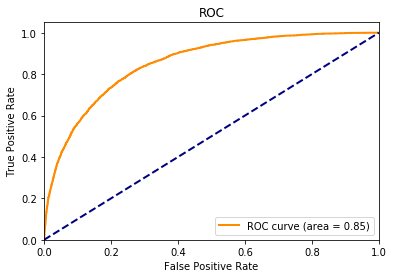

In [19]:
y_score = pipeline.decision_function(X_test)
fpr, tpr, threshold = met.roc_curve(y_test, y_score)
plt.figure()
lw = 2
auc = met.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = {:0.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

This is a lower score then before. The score did not improve above the basline with more components, so unless the goal is to reduce computation time for the classifier by sacrificing accuracy it is not very helpfull. 

#### Trying to predict sex
I tried to check if I can predict the sex of an individual based on the other attributes in the dataset (which I guess is sort of a messure of discrimination)

In [20]:
categorical_features = ['PEIOOCC', 'A_HGA', 'PRDTRACE', 'FKIND', 'A_CLSWKR', 'A_WKSTAT',
                       'A_MJIND', 'MJOCC', 'PTYN', 'LJCW', 'WEMOCG', 'MIG_CBST',
                       'MIGSAME', 'H_TYPE', 'H_LIVQRT', 'GTCBSA', 'GESTFIPS']
numerical_features = ['H_NUMPER', 'FPERSONS', 'FOWNU6', 'FOWNU18', 'A_AGE', 'A_HRS1',
                     'A_USLHRS', 'PHMEMPRS', 'HRSWK', 'HNUMFAM', 'ERN_VAL']
labels = ['A_SEX']
features = categorical_features + numerical_features
# converting colum names to uppercase
df.columns = df.columns.str.upper()
df_filt = df[features + labels]
df_filt = df_filt[(df_filt['ERN_VAL'] > 3000) & (df['ERN_VAL'] < 250000)]
categorical_index = [i for i,x in enumerate(df_filt.columns.values) if x in categorical_features]
X = df_filt[features].values
y = (df_filt.A_SEX == 1 ).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [21]:
steps = [('onehot', OneHotEncoder(categorical_features=categorical_index)),
        ('gradientboost', GradientBoostingClassifier(n_estimators=300,subsample=0.3
                                                     , learning_rate=0.2))]
pipeline = Pipeline(steps)

In [22]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=True)), ('gradientboost', GradientBoostingClassifier(criterion='friedman_mse', init=None,
    ...      presort='auto', random_state=None, subsample=0.3, verbose=0,
              warm_start=False))])

In [23]:
print(pipeline.score(X_test, y_test))

0.8604296150910479


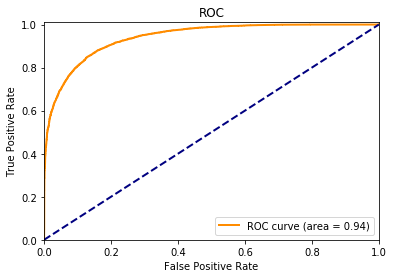

In [24]:
y_score = pipeline.decision_function(X_test)
fpr, tpr, threshold = met.roc_curve(y_test, y_score)
plt.figure()
lw = 2
auc = met.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = {:0.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [25]:
y_pred = pipeline.predict(X_test)
print(met.f1_score(y_test,y_pred))

0.8695740778479722


Apparently this is much easier task then classifying income